# Analyzing corpus V1 on topic modeling

In [19]:
import json

# Path to the JSONL file
dataset_file = 'database_packs/training_v1/joint_poems_v1.jsonl'

# Load and separate poems based on label
human_poems = []
machine_poems = []

with open(dataset_file, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        if entry['label'] == 'human':
            human_poems.append(entry['text'])
        elif entry['label'] == 'machine':
            machine_poems.append(entry['text'])

print(f"Number of human poems: {len(human_poems)}")
print(f"Number of machine poems: {len(machine_poems)}")

Number of human poems: 375
Number of machine poems: 376


In [20]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define custom stop words (add additional frequent poetic words as needed)
custom_stop_words = {
    "love", "heart", "night", "shadows", "like", "time", "light", 
    "dreams", "life", "dark", "day", "lost", "yet", "truth", "beneath"
}
# Combine with default English stop words
stop_words = set(stopwords.words("english")).union(custom_stop_words)

# Preprocessing function
def preprocess_text(text):
    # Clean and tokenize text
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W+', ' ', text.lower())  # Remove punctuation
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and len(word) > 2]

In [21]:
# Preprocess human and machine poems
processed_human_poems = [preprocess_text(poem) for poem in human_poems]
processed_machine_poems = [preprocess_text(poem) for poem in machine_poems]

In [22]:
from gensim import corpora

# Human poems dictionary and corpus
human_dictionary = corpora.Dictionary(processed_human_poems)
human_corpus = [human_dictionary.doc2bow(poem) for poem in processed_human_poems]

# Machine poems dictionary and corpus
machine_dictionary = corpora.Dictionary(processed_machine_poems)
machine_corpus = [machine_dictionary.doc2bow(poem) for poem in processed_machine_poems]

In [45]:
from gensim.models import LdaModel

# Number of topics
num_topics = 7  # Adjust as needed based on earlier analysis
alpha = 0.01
eta = 0.1

# Train LDA model for human poems
lda_model_human = LdaModel(corpus=human_corpus, 
                     id2word=human_dictionary, 
                     num_topics=num_topics, 
                     random_state=42, 
                     passes=10, 
                     alpha=alpha, 
                     eta=eta,
                     per_word_topics=True)

# Train LDA model for machine poems
lda_model_machine = LdaModel(corpus=machine_corpus, 
                             id2word=machine_dictionary, 
                             num_topics=num_topics, 
                             random_state=42, 
                             passes=10, 
                             alpha=alpha, 
                             eta=eta,
                             per_word_topics=True)

### Calculate Topic  Distribution and Entropy for both sets

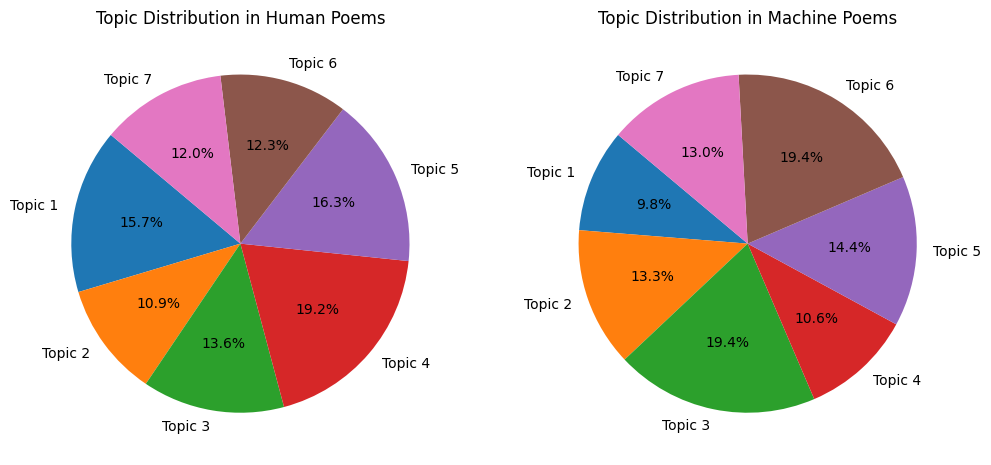

In [46]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

def calculate_topic_distribution(lda_model, corpus, num_topics):
    topic_counts = [0] * num_topics
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_counts[dominant_topic] += 1
    topic_proportions = np.array(topic_counts) / len(corpus)
    return topic_proportions

# Calculate topic distribution for both sets
human_topic_proportions = calculate_topic_distribution(lda_model_human, human_corpus, num_topics)
machine_topic_proportions = calculate_topic_distribution(lda_model_machine, machine_corpus, num_topics)

# Plot Pie Charts for Topic Distribution
plt.figure(figsize=(12, 6))

# Human Poems Topic Distribution
plt.subplot(1, 2, 1)
plt.pie(human_topic_proportions, labels=[f"Topic {i+1}" for i in range(num_topics)], autopct="%1.1f%%", startangle=140)
plt.title("Topic Distribution in Human Poems")

# Machine Poems Topic Distribution
plt.subplot(1, 2, 2)
plt.pie(machine_topic_proportions, labels=[f"Topic {i+1}" for i in range(num_topics)], autopct="%1.1f%%", startangle=140)
plt.title("Topic Distribution in Machine Poems")

plt.show()


## Entrópia vizsgálat

In [47]:
# Calculate and print entropy for both sets
human_entropy = entropy(human_topic_proportions)
machine_entropy = entropy(machine_topic_proportions)

print(f"Entropy of Topic Distribution in Human Poems: {human_entropy:.4f}")
print(f"Entropy of Topic Distribution in Machine Poems: {machine_entropy:.4f}")

def calculate_max_entropy(num_topics):
    probability = 1 / num_topics  # Uniform distribution for each topic
    max_entropy = -num_topics * (probability * np.log2(probability))
    return max_entropy

# Calculate and print the maximum entropy
max_entropy = calculate_max_entropy(num_topics)
print(f"Maximum Entropy (Uniform Distribution): {max_entropy:.4f}")

Entropy of Topic Distribution in Human Poems: 1.9284
Entropy of Topic Distribution in Machine Poems: 1.9156
Maximum Entropy (Uniform Distribution): 2.8074


## Koherencia vizsgálat

In [ ]:
from gensim.models import CoherenceModel

# Calculate coherence for the human poems
coherence_model_human = CoherenceModel(model=lda_model_human, texts=processed_human_poems, dictionary=human_dictionary, coherence='c_v')
human_coherence_score = coherence_model_human.get_coherence()
print(f"Coherence Score for Human Poems: {human_coherence_score:.4f}")

# Calculate coherence for the machine poems
coherence_model_machine = CoherenceModel(model=lda_model_machine, texts=processed_machine_poems, dictionary=machine_dictionary, coherence='c_v')
machine_coherence_score = coherence_model_machine.get_coherence()
print(f"Coherence Score for Machine Poems: {machine_coherence_score:.4f}")

In [38]:
# Display top words for each topic in both human and machine poems
num_words = 10  # Number of top words per topic

print("Top words for each topic in Human Poems:")
for topic_id in range(num_topics):
    top_words = lda_model_human.show_topic(topic_id, topn=num_words)
    print(f"Topic {topic_id + 1}: {[word for word, prob in top_words]}")

print("\nTop words for each topic in Machine Poems:")
for topic_id in range(num_topics):
    top_words = lda_model_machine.show_topic(topic_id, topn=num_words)
    print(f"Topic {topic_id + 1}: {[word for word, prob in top_words]}")

Top words for each topic in Human Poems:
Topic 1: ['black', 'one', 'know', 'nothing', 'man', 'want', 'every', 'white', 'mind', 'says']
Topic 2: ['one', 'know', 'say', 'fiddle', 'back', 'world', 'whats', 'man', 'play', 'men']
Topic 3: ['would', 'face', 'take', 'place', 'one', 'white', 'eyes', 'see', 'back', 'never']
Topic 4: ['thy', 'one', 'back', 'would', 'could', 'way', 'new', 'shed', 'know', 'water']
Topic 5: ['one', 'sea', 'would', 'never', 'even', 'could', 'shall', 'come', 'long', 'thought']
Topic 6: ['would', 'people', 'one', 'man', 'little', 'could', 'might', 'say', 'juice', 'house']
Topic 7: ['one', 'house', 'new', 'others', 'men', 'eyes', 'heavenly', 'man', 'much', 'women']
Topic 8: ['heav', 'thy', 'thir', 'thou', 'thus', 'king', 'shall', 'one', 'hell', 'deep']
Topic 9: ['river', 'one', 'say', 'water', 'rio', 'air', 'never', 'grande', 'long', 'place']
Topic 10: ['one', 'sea', 'majority', 'cruel', 'miss', 'say', 'know', 'said', 'got', 'let']

Top words for each topic in Machine 

## Standard LDA vizualizáció

### Emberi versek

In [39]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize LDA topics for Human Poems
lda_vis_human = gensimvis.prepare(lda_model_human, human_corpus, human_dictionary)
pyLDAvis.display(lda_vis_human)

### Gépi versek

In [40]:
# Visualize LDA topics for Machine Poems
lda_vis_machine = gensimvis.prepare(lda_model_machine, machine_corpus, machine_dictionary)
pyLDAvis.display(lda_vis_machine)